In [1]:
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable, plasma
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimage
from scipy import stats
import math
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.spatial.distance import jensenshannon

In [2]:
def UTC2CST(data):
    '''
    说明：将世界时（UTC）转换成北京时间（CST）
    :param data: 世界时数据 输入数据为列表 格式为：['1940-01-01T00:00:00']  注：如果'1940-01-01 00:00:00' 则 datetime.datetime.strptime('1940-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
    :return: 相应的北京时数据列表
    '''
    dataCST = []
    for id1, dataEach in enumerate(data):
        dataEachUtcTime = datetime.datetime.strptime(dataEach, '%Y-%m-%dT%H:%M:%S')
        utc_timezone = pytz.timezone('UTC')
        dataEachUtcTime = utc_timezone.localize(dataEachUtcTime)
        beijing_timezone = pytz.timezone('Asia/Shanghai')
        beijing_time = dataEachUtcTime.astimezone(beijing_timezone)
        dataCST.append(beijing_time)
    return dataCST

def return_time(years,months,days,hours,minutes):
    t1 = [str(int(years[x]))+'-'+str(int(months[x]))+'-'+str(int(days[x]))+'T'+str(int(hours[x]))+':'+str(int(minutes[x]))+':00' for x in range(len(years))]
    return t1

In [3]:
timelist = np.load('/home/penny/works/psd/inputs/radar_timelist.npy')

### Calculate Gamma distribution parameter with 3,4,6 Moment

In [4]:
#32速度（m/s）
D = np.array([0.0625,0.1875,0.3125,0.4375,0.5625,0.6875,0.8125,0.9375,1.0625,
              1.1875,1.375,1.625,1.875,2.125,2.375,2.75,3.25,3.75,4.25,4.75,5.5,
              6.5,7.5,8.5,9.5,11,13,15,17,19,21.5,24.5])
#32直径（mm）
V = np.array([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.1,1.3,1.5,1.7,
              1.9,2.2,2.6,3,3.4,3.8,4.4,5.2,6,6.8,7.6,8.8,10.4,12,13.6,15.2,
              17.6,20.8])

D[8:24] = (1.075 - 0.075*D[8:24])*D[8:24]
D[24:] = D[24:]*0.7

#采样面积不固定的
A = np.zeros((32,1),dtype='float')
#32直径通道间隔
detaD = np.zeros((32,1),dtype='float')
#通道间隔（mm）
detaD[0]=D[1]-D[0]
for i in range(1,32):
    detaD[i]=D[i]-D[i-1]
#采样面积  m**2 
for i in range(32):
     A[i,0] = 0.18*(0.03-(D[i]/1000))
#month_list = ['01','03','05','07','08','10','12']

In [5]:
delta_h = 1+3.68*10**-5*3465 + 1.71*10**-9*3465**2
Vt = delta_h*(9.65-10.3/(np.exp(0.6*D)))

In [6]:
bac_list = np.load('./inputs/bac_list_32_mie_cla_2.npy')

In [7]:
# t [2,31]
t_grid = np.arange(2,32,1)
bac_list_t = np.load('./inputs/bac_list_32_mie_cla_2_t.npy')
ext_list_t = np.load('./inputs/ext_list_32_mie_cla_2_t.npy')

In [9]:
import os
from scipy.special import gamma

def find_DSD_data(filename1):
    psd_I = pd.read_csv('/home/penny/data/hongyuan_rpsd/2024_results/'+filename1[0],delimiter='\t',header = None)
    for nn in range(len(filename1))[1:]:
        psd_It = pd.read_csv('/home/penny/data/hongyuan_rpsd/2024_results/'+filename1[nn],delimiter='\t',header = None)
        psd_I = pd.concat((psd_I,psd_It))
    psd_I.index = range(psd_I.shape[0])
    del psd_I[37]
    # Time transfering  UTC-->beijingshi 
    UTC_list  = return_time(psd_I[0].values,psd_I[1].values,psd_I[2].values,psd_I[3].values,psd_I[4].values)
    CST_list  = UTC2CST(UTC_list)
    CST_time  = [x.strftime('%Y%m%d%H%M%S') for x in CST_list]
    CST_time  = np.array(CST_time)

    psd_I[0]  = [int(x[:4]) for x in CST_time]
    psd_I[1] = [int(x[4:6]) for x in CST_time]
    psd_I[2]   = [int(x[6:8]) for x in CST_time]
    psd_I[3]  = [int(x[8:10]) for x in CST_time]
    psd_I[4]= [int(x[10:12]) for x in CST_time]
    return psd_I
    
def find_disdrometer(filename1):
    # rain particle distribution probe reading
    psd_I = pd.read_csv('/home/penny/data/hongyuan_rpsd/2024_results/'+filename1[0],delimiter='\t',header = None)
    #del psd_I[14]
    psd_I.columns  = ['year','month','day','hour','minute','ntotal','NT','Z','Dm','RR','RWC','Nw','v','D0','M1','M2','M3','M4','M5','M6']
    
    for nn in range(len(filename1))[1:]:
        psd_It = pd.read_csv('/home/penny/data/hongyuan_rpsd/2024_results/'+filename1[nn],delimiter='\t',header = None)
        #del psd_It[14]
        psd_It.columns  = ['year','month','day','hour','minute','ntotal','NT','Z','Dm','RR','RWC','Nw','v','D0','M1','M2','M3','M4','M5','M6']
        psd_I = pd.concat((psd_I,psd_It))
    psd_I.index = range(psd_I.shape[0])
    # Time transfering  UTC-->beijingshi 
    UTC_list  = return_time(psd_I['year'].values,psd_I['month'].values,psd_I['day'].values,psd_I['hour'].values,psd_I['minute'].values)
    CST_list  = UTC2CST(UTC_list)
    CST_time  = [x.strftime('%Y%m%d%H%M%S') for x in CST_list]
    CST_time  = np.array(CST_time)

    #UTC_list  = return_time1(psd_I['year'].values,psd_I['month'].values,psd_I['day'].values,psd_I['hour'].values,psd_I['minute'].values)
    #CST_time  = np.array(UTC_list)

    psd_I['year']  = [int(x[:4]) for x in CST_time]
    psd_I['month'] = [int(x[4:6]) for x in CST_time]
    psd_I['day']   = [int(x[6:8]) for x in CST_time]
    psd_I['hour']  = [int(x[8:10]) for x in CST_time]
    psd_I['minute']= [int(x[10:12]) for x in CST_time]
    return psd_I

In [10]:
def argclosest(array, value, retvalue=False):
    """Returns the index of the closest value in array.  """
    idx = np.abs(array - value).argmin()

    return (idx, array[idx]) if retvalue else idx

In [11]:
path = '/home/penny/data/MWR_2024_hongyuan_product/'
MWR_files = os.listdir(path)

def read_MWR_data(filepath):
    with open(path+filepath, 'r') as file:
        data = file.read()
    
    a = data.split('\n')
    colname = a[2].split(',')
    datas = pd.DataFrame(np.zeros((4,len(colname))), columns = colname)
    datas.iloc[0] = a[3].split(',')
    datas.iloc[1] = a[4].split(',')
    datas.iloc[2] = a[5].split(',')
    datas.iloc[3] = a[6].split(',')
    return datas

In [12]:
import warnings
 # 忽略所有警告
warnings.filterwarnings('ignore')

In [18]:
from scipy.stats import gaussian_kde
def cal_error(s1,s2):
    corr = pd.Series(s1).corr(pd.Series(s2))
    corr = round(corr,2)
    #rmse = sqrt(mean_squared_error(pd.Series(s1),pd.Series(s2)))
    #rmse = round(rmse,2)
    ab = (s2-s1).mean()
    reletive_error = abs(s1-s2)
    reletive_error1 = reletive_error/s2
    return ab, corr

In [19]:
date_list =[x.split('3_')[1][:8] for x in os.listdir('/home/penny/data/hongyuan_2024_radar/')]
date_list = np.unique(np.array(date_list))

In [20]:
date_list =['20240601', '20240602', '20240603', '20240604', '20240605',
           '20240606', '20240607', '20240608', '20240609', '20240610',
           '20240611', '20240612', '20240613', '20240614', '20240615',
           '20240616', '20240617', '20240618', '20240619', '20240620',
           '20240621', '20240622', '20240623', '20240624', '20240625',
           '20240626', '20240627', '20240628', '20240629', '20240630',
           '20240701', '20240702', '20240703', '20240704', '20240705',
           '20240706', '20240707', '20240708', '20240709', '20240710',
           '20240711', '20240712', '20240713', '20240714', '20240715',
           '20240716', '20240717', '20240718', '20240719', '20240720',
           '20240721', '20240722', '20240723', '20240724', '20240725',
           '20240726', '20240727', '20240728', '20240729', '20240730',
           '20240731', '20240801', '20240802', '20240803', '20240804',
           '20240805', '20240806', '20240807', '20240808', '20240809',
           '20240810', '20240811', '20240812', '20240813', '20240814',
           '20240815', '20240816', '20240817', '20240818', '20240820',
           '20240821', '20240822', '20240823', '20240824', '20240825',
           '20240826', '20240827', '20240828', '20240829', '20240830',
           '20240831']

In [27]:
    psd_i_z   = []
    psd_i_z_s = []
    psd_i_v_s = [] 
    psd_i_v   = []
    N0        = []
    miu       = []
    sigma     = []
    Z_list    = []
    V_list    = []

In [ ]:
for ii in range(len(date_list)):
    try:
        # ---------------------------------xlabel setting-------------------------
        # ---------------------------------reading radar xinqixiang---------------
        filename = os.listdir('/home/penny/data/hongyuan_rpsd/2024_results/')
        # three days for time matching
        date_name = date_list[ii-1]
        date_name1= date_list[ii]
        date_name2= date_list[ii+1]
        filename1 = [x for x in filename if (x[3:11] == date_name)or(x[3:11] == date_name1)or((x[3:11] == date_name2))]
        # rain particle distribution probe reading
        psd_I = pd.read_csv('/home/penny/data/hongyuan_rpsd/2024_results/'+filename1[0],delimiter='\t',header = None)
        #del psd_I[14]
        psd_I.columns  = ['year','month','day','hour','minute','ntotal','NT','Z','Dm','RR','RWC','Nw','v','D0','M1','M2','M3','M4','M5','M6']
        
        for nn in range(len(filename1))[1:]:
            psd_It = pd.read_csv('/home/penny/data/hongyuan_rpsd/2024_results/'+filename1[nn],delimiter='\t',header = None)
            #del psd_It[14]
            psd_It.columns  = ['year','month','day','hour','minute','ntotal','NT','Z','Dm','RR','RWC','Nw','v','D0','M1','M2','M3','M4','M5','M6']
            psd_I = pd.concat((psd_I,psd_It))
        psd_I.index = range(psd_I.shape[0])
        # Time transfering  UTC-->beijingshi 
        UTC_list  = return_time(psd_I['year'].values,psd_I['month'].values,psd_I['day'].values,psd_I['hour'].values,psd_I['minute'].values)
        CST_list  = UTC2CST(UTC_list)
        CST_time  = [x.strftime('%Y%m%d%H%M%S') for x in CST_list]
        CST_time  = np.array(CST_time)
    
        #UTC_list  = return_time1(psd_I['year'].values,psd_I['month'].values,psd_I['day'].values,psd_I['hour'].values,psd_I['minute'].values)
        #CST_time  = np.array(UTC_list)  

        psd_I['year']  = [int(x[:4]) for x in CST_time]
        psd_I['month'] = [int(x[4:6]) for x in CST_time]
        psd_I['day']   = [int(x[6:8]) for x in CST_time]
        psd_I['hour']  = [int(x[8:10]) for x in CST_time]
        psd_I['minute']= [int(x[10:12]) for x in CST_time]
    
        # ---------------------------------reading radar xinqixiang---------------
        filename = os.listdir('/home/penny/data/hongyuan_rpsd/2024_results/')
        filename = [x for x in filename if x[:3]=='DSD']
        # three days for time matching
        date_name = date_list[ii-1]
        date_name1= date_list[ii]
        date_name2= date_list[ii+1]
        filename1 = [x for x in filename if (x[6:-4] == date_name)or(x[6:-4] == date_name1)or((x[6:-4] == date_name2))]
        # rain particle distribution probe reading
        psd_D = pd.read_csv('/home/penny/data/hongyuan_rpsd/2024_results/'+filename1[0],delimiter='\t',header = None)
        for nn in range(len(filename1))[1:]:
            psd_Dt = pd.read_csv('/home/penny/data/hongyuan_rpsd/2024_results/'+filename1[nn],delimiter='\t',header = None)
            psd_D = pd.concat((psd_D,psd_Dt))
        psd_D.index = range(psd_D.shape[0])
        del psd_D[37]
        # Time transfering  UTC-->beijingshi 
        UTC_list  = return_time(psd_D[0].values,psd_D[1].values,psd_D[2].values,psd_D[3].values,psd_D[4].values)
        CST_list  = UTC2CST(UTC_list)
        CST_time  = [x.strftime('%Y%m%d%H%M%S') for x in CST_list]
        CST_time  = np.array(CST_time)
        
        psd_D[0]  = [int(x[:4]) for x in CST_time]
        psd_D[1] = [int(x[4:6]) for x in CST_time]
        psd_D[2]   = [int(x[6:8]) for x in CST_time]
        psd_D[3]  = [int(x[8:10]) for x in CST_time]
        psd_D[4]= [int(x[10:12]) for x in CST_time]
        
        ref=np.loadtxt('/home/penny/data/radar_results/'+date_name1+'dbz_new.txt',delimiter=' ')
        ref[ref==-327.68]=np.nan
        [Z_list.append(x) for x in ref.T[6,:]]

        #ref=np.loadtxt('/home/penny/data/radar_results_yuanwang/'+date_name1+'dbz_new.txt',delimiter=' ')
        #ref[ref==-51.0]=np.nan
        #[Z_list.append(x) for x in ref.T[6,:]]
    
        vim=np.loadtxt('/home/penny/data/radar_results/'+date_name1+'v_new.txt',delimiter=' ')
        vim[vim==-327.68]=np.nan
        [V_list.append(abs(x)) for x in vim.T[6,:]]

        #vim=np.loadtxt('/home/penny/data/radar_results_yuanwang/'+date_name1+'v_new.txt',delimiter=' ')
        #vim[vim==-25.40]=np.nan
        #[V_list.append(abs(x)) for x in vim.T[6,:]]
        
        for ti in timelist:
            year  = int(date_list[ii][:4])
            month = int(date_list[ii][4:6])
            days  = int(date_list[ii][6:8])
            hours = int(ti[:2])
            minus = int(ti[2:4])
            da_idx = psd_I[(psd_I['year'] == year) & (psd_I['month'] == month) & (psd_I['day'] == days) & (psd_I['hour'] == hours) & (psd_I['minute'] == minus)].index
            da     = psd_I.iloc[da_idx,:]
    
            DSD_idx = psd_D[(psd_D[0] == year) & (psd_D[1] == month) & (psd_D[2] == days) & (psd_D[3] == hours) & (psd_D[4] == minus)].index
            DSD     = psd_D.iloc[DSD_idx,:]

            # 加入微波辐射计的温度产品
            if os.path.exists(path+ 'T_UPAR_I_56173_'+date_list[ii]+ti+'_P_YMWR_TK001_CP_MM.TXT'):
                datas = read_MWR_data('T_UPAR_I_56173_'+date_list[ii]+ti+'_P_YMWR_TK001_CP_MM.TXT')
                tem_210 = float(datas.iloc[0]['0.200(km)'])
                t_grid_idx = argclosest(tem_210,t_grid)
                bac_list = bac_list_t[t_grid_idx]  
                #print(tem_210)
            if os.path.exists(path+ 'T_UPAR_I_56173_'+date_list[ii]+ti+'_P_YMWR_TK001_CP_MM.TXT') == False:
                tem_210 = 14
                t_grid_idx = argclosest(tem_210,t_grid)
                bac_list = bac_list_t[t_grid_idx]                  
                
            #print(da)
            if (len(da) == 0) or (len(DSD) == 0):
                psd_i_z.append(-99999)
                psd_i_v.append(-99999)
                N0.append(-99999)
                miu.append(-99999)
                sigma.append(-99999)
                psd_i_z_s.append(-99999)
                psd_i_v_s.append(-99999)
            if len(da) >= 1:

                #psd_i_time.append(ti)
    
                Z = 0
                
                upper = 0
                under = 0

                for iii in range(len(D))[2:]:
                    data = DSD.values[0][5:]
                    Z += (data[iii]*(0.25*math.pi*bac_list[iii])*D[iii]**2*detaD[iii][0])
                    upper += data[iii]*(bac_list[iii])*detaD[iii][0]*Vt[iii]
                    under += data[iii]*(bac_list[iii])*detaD[iii][0]
                
                #Z = (8.62**4)/(3.14156**5 * 0.88)*Z
                Z = (8.62**4)/(math.pi**5 * 0.88)*Z
                Z = 10*math.log10(Z)
                V_sim = (upper/under)
                
                psd_i_z_s.append(Z)
                psd_i_v_s.append(V_sim)
                psd_i_z.append(da['Z'].values[0])
                psd_i_v.append(da['v'].values[0])
        #plt.savefig('/home/penny/data/radar_results/'+date_name1+'_35GHz_radar_vanaylze.png',bbox_inches = 'tight')
    except:
        continue


In [36]:
print(np.array(psd_i_z_s).shape,np.array(Z_list).shape)

(38880,) (38880,)


In [24]:
    #none_1 = np.where(np.array(psd_i_z) > -50)[0]
    none_1 = np.where(np.array(psd_i_z_s) > -50)[0]
    none_2 = np.where(np.isnan(np.array(Z_list)) == False)[0]
    none_i = np.intersect1d(none_1,none_2)
    #yy = np.array(psd_i_z)[none_i]
    yy = np.array(psd_i_z_s)[none_i]
    xx = np.array(Z_list)[none_i]
    ab_e, corr  = cal_error(xx, yy)[:1]

    xy = np.vstack([xx, yy])
    z = gaussian_kde(xy)(xy)

In [39]:
pearson_corr = round(pearson_corr[0,1],2)

In [71]:
pearson_corr

0.8964536580805382

In [56]:
pearson_corr = np.corrcoef(xx, yy)[0,1]

# 计算JSD（需要先标准化预测和实际值）# y_test_hist：将实际值（y_test）分成20个区间，并计算每个区间的频率
y_test_hist, _ = np.histogram(xx, bins=20, density=True) # 'bins=20'将数据分为20个区间，'density=True'使得每个区间的值归一化为概率密度
# y_pred_hist：将预测值（y_pred）分成20个区间，并计算每个区间的频率
y_pred_hist, _ = np.histogram(yy, bins=20, density=True) # 'bins=20'将数据分为20个区间，'density=True'使得每个区间的值归一化为概率密度
# 计算JSD
jsd = jensenshannon(y_test_hist, y_pred_hist)
ab_e = cal_error(xx, yy)[:1]

In [57]:
jsd

0.3684210095144212

In [67]:
ab_e

(3.628420160850238,)

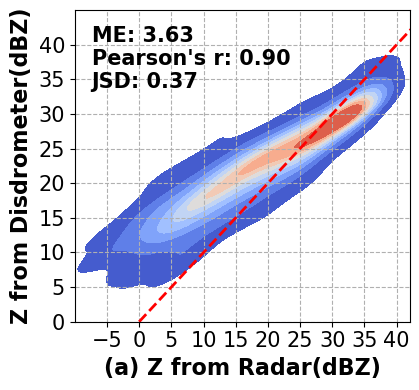

In [97]:
fig, ax = plt.subplots(figsize=(4.3, 4))
sns.kdeplot(x=xx, y=yy, cmap='coolwarm', shade=True, ax = ax)
plt.plot([0,45],[0,45],c = 'red',linewidth = 2, linestyle = '--')
plt.grid(True,linestyle = '--')
plt.xticks([-5,0,5,10,15,20,25,30,35,40])
plt.yticks([-5,0,5,10,15,20,25,30,35,40])
plt.xlim(-10,42)
plt.ylim(0,45)
plt.tick_params(labelsize = 15)
plt.xlabel('(a) Z from Radar(dBZ)',size = 16,fontweight='bold')
plt.ylabel('Z from Disdrometer(dBZ)',size = 16,fontweight='bold')
test_metrics_text = f"ME:{ab_e[0]: .2f}\nPearson's r: {pearson_corr:.2f}\nJSD: {jsd:.2f}"
ax.text(0.05, 0.95,f"{test_metrics_text}",transform=ax.transAxes,fontsize=15,fontweight='bold',verticalalignment='top',horizontalalignment='left',color='black')
plt.tight_layout()
plt.savefig('./results/wok05/2024_radar_dis_obs_compara_a.png',bbox_inches = 'tight')

In [98]:
yy = np.array(psd_i_v)[none_i]
xx = np.array(V_list)[none_i]
pearson_corr = np.corrcoef(xx, yy)[0,1]

# 计算JSD（需要先标准化预测和实际值）# y_test_hist：将实际值（y_test）分成20个区间，并计算每个区间的频率
y_test_hist, _ = np.histogram(xx, bins=20, density=True) # 'bins=20'将数据分为20个区间，'density=True'使得每个区间的值归一化为概率密度
# y_pred_hist：将预测值（y_pred）分成20个区间，并计算每个区间的频率
y_pred_hist, _ = np.histogram(yy, bins=20, density=True) # 'bins=20'将数据分为20个区间，'density=True'使得每个区间的值归一化为概率密度
# 计算JSD
jsd = jensenshannon(y_test_hist, y_pred_hist)
ab_e = cal_error(xx, yy)[:1]

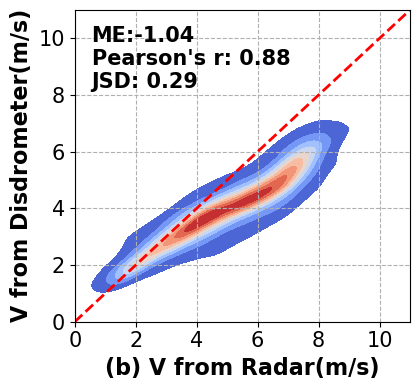

In [99]:
fig, ax = plt.subplots(figsize=(4.3, 4))
sns.kdeplot(x=xx, y=yy, cmap='coolwarm', shade=True, ax = ax)
plt.plot([0,12],[0,12],c = 'red',linewidth = 2, linestyle = '--')
plt.grid(True,linestyle = '--')
plt.xticks([0,2,4,6,8,10,12])
plt.yticks([0,2,4,6,8,10,12])
plt.xlim(0,11)
plt.ylim(0,11)
plt.tick_params(labelsize = 15)
plt.xlabel('(b) V from Radar(m/s)',size = 16,fontweight='bold')
plt.ylabel('V from Disdrometer(m/s)',size = 16,fontweight='bold')
test_metrics_text = f"ME:{ab_e[0]: .2f}\nPearson's r: {pearson_corr:.2f}\nJSD: {jsd:.2f}"
ax.text(0.05, 0.95,f"{test_metrics_text}",transform=ax.transAxes,fontsize=15,fontweight='bold',verticalalignment='top',horizontalalignment='left',color='black')
plt.tight_layout()
plt.savefig('./results/wok05/2024_radar_dis_obs_compara_b.png',bbox_inches = 'tight')